In [42]:
import torch
import numpy as np
import os
from torch import nn
import torch.nn.utils.parametrize as parametrize
from torch.nn.utils.parametrizations import orthogonal  
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

dtype = torch.float32
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
torch.set_default_dtype(dtype)

class Engel2022Fit(nn.Module):
    def __init__(self,N,n,N_in):
        """
        In the constructor we instantiate parameters and assign them as
        member parameters.
        """
        super().__init__()
        self.matB = nn.Parameter(torch.rand(N,N))
        self.wIn = nn.Parameter(torch.eye(n,N_in))#nn.Parameter(torch.tensor(wIn))#nn.Parameter(torch.eye(n,N_in))
        self.wRec = nn.Parameter(torch.zeros(n,n))#nn.Parameter(torch.tensor(wRec))#nn.Parameter(torch.zeros(n,n))
        
        self.leakyRNN = leakyRNN(N_in,n, nonlin=nn.ReLU(),bias=False,init_state_train=False)
        self.leakyRNN.wRec.weight = self.wRec
        self.leakyRNN.wIn.weight = self.wIn

        
        # self.embed = nn.Linear(in_features=n,out_features=N,bias=False)
        # orthogonal(self.embed)#,orthogonal_map='cayley')
        # self.embed.parametrizations.weight.original = self.matB

        # self.embed.weight = self.matB
        
        self.padding = nn.ZeroPad1d((0,N-n))
        
        self.embed = nn.Linear(N,N,bias=False)
        parametrize.register_parametrization(self.embed,"weight",Orthonormal())
        self.embed.parametrizations.weight.original = self.matB
     
        
    def forward(self, u):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x= self.leakyRNN(u)
        x_padded = self.padding(x)
        y = self.embed(x_padded)
        # y = self.embed(x)
        
        return y
        
class Orthonormal(nn.Module):
    def forward(self,B):
        N = B.shape[0]
        A = B - B.T # skew-symmetric
        Q = torch.linalg.solve ( (torch.eye(N) + A), (torch.eye(N) - A), left=False)
        return Q

class leakyRNN(nn.Module):
    def __init__(self,n_in,n_hidden,
                         dtype=dtype,
                         alpha=0.1,nonlin=nn.Softplus(),#nn.ReLU()
                         bias=True,init_state_train=True):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        self.n_in = n_in
        self.n_hidden = n_hidden
        self.dtype = dtype
        self.alpha = alpha # dt/tau, default is .1 (10ms/100ms)
        self.non_linearity = nonlin

        self.wRec = nn.Linear(n_hidden, n_hidden, bias=False)
        self.wIn = nn.Linear(n_in, n_hidden, bias=False)
        self.device = self.wRec.weight.device

        if bias:
            self.b_rec = nn.Parameter(torch.zeros(n_hidden)).to(self.device)
        else:
            self.b_rec = torch.zeros(n_hidden,requires_grad=False).to(self.device)
        
        if init_state_train:
            self.y0 = nn.Parameter(torch.zeros(n_hidden)).to(self.device)
        else:
            self.y0 = torch.zeros(n_hidden,requires_grad=False).to(self.device)

    
    
    def recurrent_timestep(self,xt,state):
        """ Recurrent time step.

        Given input and previous state, outputs the next state of the network.
        """
        new_state = ((1-self.alpha) * state) \
                    + self.alpha * ( 
                        self.wRec(self.non_linearity(state))
                        + self.wIn(xt)
                        + self.b_rec)\
                    # + rec_noise + input_noise
        return new_state
        
    
    def forward(self,x,y0=None):    
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        device = self.device
        dtype = self.dtype
        
        if y0 is None: y0=self.y0
        y = y0.to(device,dtype=dtype)
        
        N_batch,N_timeStep, _n_in = x.shape
        hidden = torch.zeros((N_batch, N_timeStep, self.n_hidden),
                             device = device, dtype=dtype)
        
        for iTimeStep in range(N_timeStep):
            xt = x[:,iTimeStep,:].to(device,dtype=dtype)
            y = self.recurrent_timestep(xt,y)

            hidden[:,iTimeStep,:] = y

        return hidden
def get_data_weight(dataDir):
    # ---- load data and copy to GPU
    dataPath = os.path.join(dataDir,'activitityTest.npz')
    with np.load(dataPath) as dataNumpy:
        xNumpy = dataNumpy['x'][:,0:250,0:2]
        model_output_Numpy = dataNumpy['model_output']
        model_state_Numpy = dataNumpy['model_state'][:,0:250,:]
    N_batch,N_timeStep,N_in = xNumpy.shape
    xTorch = torch.tensor(xNumpy)
    N_out = model_output_Numpy.shape[-1]
    model_output_Torch = torch.tensor(model_output_Numpy)
    N_node = model_state_Numpy.shape[-1]
    model_state_Torch = torch.tensor(model_state_Numpy)

    u = xTorch.to(dtype)
    y = model_state_Torch.to(dtype)

    N= N_node
    n=2
    fitSavePath = os.path.join(dataDir,f'lowDimFit{n}.pth')    

    return dataPath,fitSavePath,N,n,N_in,N_batch,u,y

def get_loss(dataDir):

    dataPath,fitSavePath,N,n,N_in,N_batch,u,y = get_data_weight(dataDir)

    try:
        model = Engel2022Fit(N,n,N_in)
        model.load_state_dict(torch.load(fitSavePath))
    except RuntimeError:
        model = Engel2022Fit(N,n,2)
        u = u[:,:,0:2]
        model.load_state_dict(torch.load(fitSavePath))
    criterion = torch.nn.MSELoss(reduction='sum')
    y_pred = model(u)
    loss = criterion(y_pred, y)
    # print('loss: ', loss.item())
    return loss.item()

def get_loss_norm(dataDir):

    dataPath,fitSavePath,N,n,N_in,N_batch,u,y = get_data_weight(dataDir)

    try:
        model = Engel2022Fit(N,n,N_in)
        model.load_state_dict(torch.load(fitSavePath))
    except RuntimeError:
        model = Engel2022Fit(N,n,2)
        u = u[:,:,0:2]
        model.load_state_dict(torch.load(fitSavePath))
    criterion = torch.nn.MSELoss(reduction='sum')
    y_pred = model(u)
    loss = criterion(y_pred, y)
    denom = criterion(torch.zeros_like(y),y)
    # print('loss: ', loss.item())
    return loss.item()/denom.item()
            
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from pathlib import Path
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression
import pandas as pd
import seaborn as sns

csv_juice = pd.read_csv('/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/0-analysis/activityAnalysis.juiceTaskDefault.csv',
    header=1)    

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression,LinearRegression

def angle_between_axis(v1,v2):
    inner_product = np.dot(v1,v2)
    cosDist = inner_product/(np.linalg.norm(v1)*np.linalg.norm(v2))
    return np.arccos(cosDist)

def angleJuice(param,stimSet,noise=0.001):
    model_states,time = task(stimSet,param,noise=0.001)
    linearFit = LinearRegression().fit(stimSet[:,0].reshape(-1,1),model_states[100,:,:].T)
    A_axis = linearFit.coef_[:,0]
    B_axis = A_axis[::-1]
    angle = angle_between_axis(A_axis,B_axis) *180/np.pi
    return angle

def newX(x,s0,s1,param,alpha=0.1):
    phi,w_inh,w_in,mu,w_exc = param
    newX=np.zeros_like(x)

    newX[0] = alpha * (w_exc*phi(x[0]) - w_inh * phi(x[1]) + w_in*s0 - mu*w_in*s1) + (1-alpha)*x[0]
    newX[1] = alpha * (w_exc*phi(x[1]) - w_inh * phi(x[0]) + w_in*s1 - mu*w_in*s0) + (1-alpha)*x[1]
    return newX    
relu = lambda x: x*(x>0)
softPlus = lambda x,beta=1: np.log(1+np.exp(beta*x))/beta
def set_param(phi=relu,w_inh=0.1,w_in=2,mu=0.25,w_rec=1):
    return phi,w_inh,w_in,mu,w_rec

def task(stimSet,param,Tstim=500,dt=10,noise=0.0):
    T=Tstim/dt*4;T=int(T)
    K = stimSet.shape[0]
    x = np.zeros((T+1,2,K))
    time = np.arange(0,T)
    for t in time:
        if t==0: pass
        if t<(Tstim/dt): s0,s1=stimSet[:,0],np.zeros(K)
        if (t<(Tstim/dt)*3)&(t>=(Tstim/dt)*2): s0,s1=np.zeros(K),stimSet[:,1]
        if (t>=(Tstim/dt))&(t<(Tstim/dt)*2): s0,s1=np.zeros(K),np.zeros(K)
        if (t>=(Tstim/dt)*3): s0,s1=np.zeros(K),np.zeros(K)
        # print(t,s0,s1)
        x[t+1] = newX(x[t],s0,s1,param) + noise*np.random.randn(2,K)*np.sqrt(dt)
        # ss.append(s)
    return x[0:-1],time*dt


def stimSet_Kuntan(order='AB'):
    stimSet = np.array([[0, 1], 
                        [0, 2], 
                        [1, 0], 
                        [1, 3], 
                        [1, 4],
                        [2, 1],
                        [2, 2],
                        [2, 3],
                        [2, 4],
                        [2, 6], 
                        [3, 2],
                        [3, 3],
                        [3, 8],
                        [4, 4],
                        # [3, 6],
                        # [4, 8]
                        ],dtype=float)
    stimSet[:,0]*=(1.7/8)
    stimSet[:,1]/=8
    stimSet_r = stimSet[:,[1,0]]
    if order=='AB':
        return stimSet
    else:
        return stimSet_r

def importAndPreprocess(dirPath,activityFileName='activitityTestGrid.npz'):
    import os
    import sys

    
    with np.load(os.path.join(dirPath,activityFileName),allow_pickle=True) as f:
        x = f['x']
        trial_params = f['trial_params']
        model_output = f['model_output']
        model_state = f['model_state']
        mask = f.get('mask', None)
    
    if mask is None:
        temp = np.mean(model_output[:,300:,:],1)
    else: 
        temp = np.mean(mask * model_output,1)
    choiceLR = temp[:,1]>temp[:,0]
    choiceLR = choiceLR*2-1 # pos right high, neg left high
    
    choiceFrame = [trial_params[i]['choiceFrame'] for i in range(len(trial_params))]
    
    
    locAB = [(1 if trial_params[i]['locAB']=='AB' or trial_params[i]['locAB']=='12' else -1) for i in range(len(trial_params))]
    loc12 = locAB
    seqAB = [(1 if trial_params[i]['seqAB']=='AB' else -1) for i in range(len(trial_params))]
    
    choiceAB = np.array([(choiceLR[i] * locAB[i] if choiceFrame[i]=='juice' else choiceLR[i] * locAB[i] * seqAB[i]) for i in range(len(trial_params)) ])  # pos B neg A
    choice12 = np.array([(choiceAB[i] * seqAB[i] if choiceFrame[i]=='juice' else choiceLR[i] * locAB[i]) for i in range(len(trial_params)) ])  # pos 2 neg 1
    choiceAB = np.array(['B' if choiceAB[i]>0 else 'A' for i in range(len(trial_params))])
    choice12 = np.array(['2' if choice12[i]>0 else '1' for i in range(len(trial_params))])
    
    qAs = np.array([trial_params[i]['qA'] for i in range(len(trial_params))])
    qBs = np.array([trial_params[i]['qB'] for i in range(len(trial_params))])
    seqAB = np.array([trial_params[i]['seqAB']for i in range(len(trial_params))])

    return x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB

def plotVecField(model,ax=None,

    min_h1 = -1,
    min_h2= -2,
    max_h1 = 5,
    max_h2 = 10,
    N_grid = 25):

    xpc,ypc = np.meshgrid(np.linspace(min_h1,max_h1,N_grid),np.linspace(min_h2,max_h2,N_grid))
    state_grid = np.vstack((xpc.reshape(-1),ypc.reshape(-1))).T
    state_grid = torch.tensor(state_grid,dtype=dtype)

    N_in = model.wIn.shape[1]
    try:
        new_state = model.leakyRNN.recurrent_timestep(torch.zeros((N_grid*N_grid,2)),torch.tensor(state_grid))
    except RuntimeError:
        new_state = model.leakyRNN.recurrent_timestep(torch.zeros((N_grid*N_grid,N_in)),torch.tensor(state_grid))

    vec_grid = (new_state - state_grid)/10
    vec_grid = vec_grid.reshape((N_grid,N_grid,2))
    vec_grid = vec_grid.detach().cpu().numpy()

    if ax == None:
        fig,ax=plt.subplots(dpi=200,figsize=(4,3))

    quiver=ax.quiver(xpc,ypc,vec_grid[:,:,0],vec_grid[:,:,1])
    ax.set_xlabel('A axis ')
    ax.set_ylabel('B axis ')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.set_aspect('equal','box')
    return quiver

In [43]:
dirPath = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20231204-15-12_5_'
# dirPath = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20231204-17-12_14_'
dataPath,fitSavePath,N,n,N_in,N_batch,u,y = get_data_weight(dirPath)
Q = np.load(os.path.join(dirPath,'circuitInfer/Q.npy'))
wRec = np.load(os.path.join(dirPath,'circuitInfer/wRec.npy'))
wIn = np.load(os.path.join(dirPath,'circuitInfer/wIn.npy'))

x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(dirPath,'activitityTest.npz')

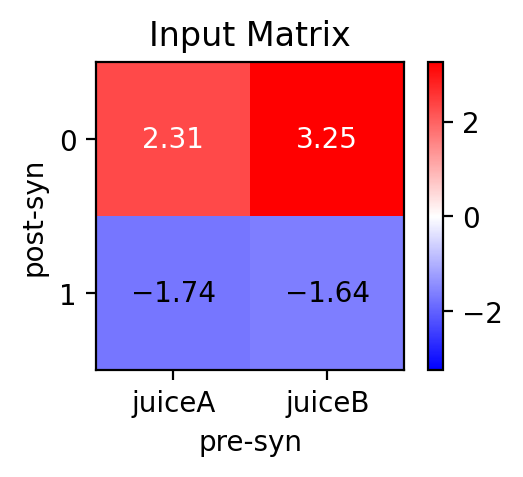

In [44]:
from heatmap import annotate_heatmap
fig = plt.figure(figsize=(3,2),dpi=200)
im=plt.imshow(wIn[0:2,0:2],cmap='bwr',
           vmin=-np.max(np.abs(wIn[0:2,0:2])),vmax=np.max(np.abs(wIn[0:2,0:2]))
          )
annotate_heatmap(im)
plt.colorbar()
plt.xlabel('pre-syn')
plt.ylabel('post-syn')
plt.xticks((0,1),['juiceA','juiceB'])
plt.yticks((0,1))
plt.title('Input Matrix')
fig.savefig('/gpfsnyu/scratch/jtg374/psychrnn/Figure/Fig6/Fig6B.eps')

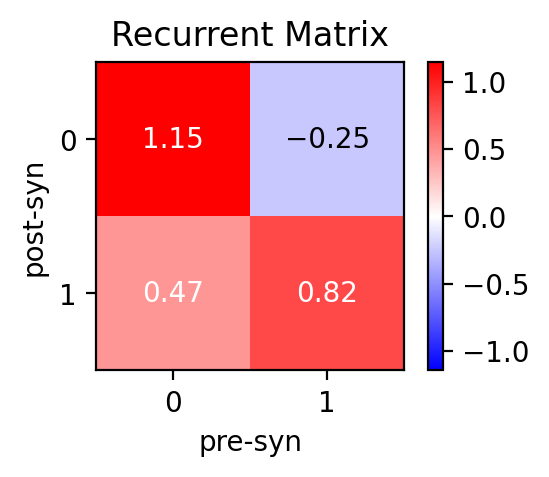

In [45]:
fig=plt.figure(figsize=(3,2),dpi=200)
im=plt.imshow(wRec,cmap='bwr',
           vmin=-np.max(np.abs(wRec)),vmax=np.max(np.abs(wRec))
          )
annotate_heatmap(im)
plt.colorbar()
plt.xlabel('pre-syn')
plt.ylabel('post-syn')
plt.xticks((0,1))
plt.yticks((0,1))
plt.title('Recurrent Matrix')
fig.savefig('/gpfsnyu/scratch/jtg374/psychrnn/Figure/Fig6/Fig6A.eps')

In [46]:
model2d = Engel2022Fit(N,n,N_in)
model2d.load_state_dict(torch.load(fitSavePath))
y_pred = model2d(u)
state_pred_project = y_pred.cpu().detach().numpy() @ Q
# model_state_project = y.cpu().detach().numpy() @ Q
model_state_project = model_state[:,0:250,:] @ Q

In [47]:
def getTrialAverage(model_state,qA,qB,seqAB='AB'):
    qAs = np.array([trial_params[i]['qA'] for i in range(len(trial_params))])
    qBs = np.array([trial_params[i]['qB'] for i in range(len(trial_params))])
    seqABs = np.array([trial_params[i]['seqAB']for i in range(len(trial_params))])
    idx = (qAs==qA) & (qBs==qB) & (seqABs==seqAB)
    return model_state[idx,:,:].mean(axis=0),model_state[idx,:,:].std(axis=0)

# getTrialAverage(model_state_project,2,2)
offerpair_Kuntan = np.array([[0, 1], 
                        [0, 2], 
                        [1, 0], 
                        [1, 3], 
                        [1, 4],
                        [2, 1],
                        [2, 2],
                        [2, 3],
                        [2, 4],
                        [2, 6], 
                        [3, 2],
                        [3, 3],
                        [3, 8],
                        [4, 4],
                        # [3, 6],
                        # [4, 8]
                        ],dtype=float)

(-2.0, 20.0)

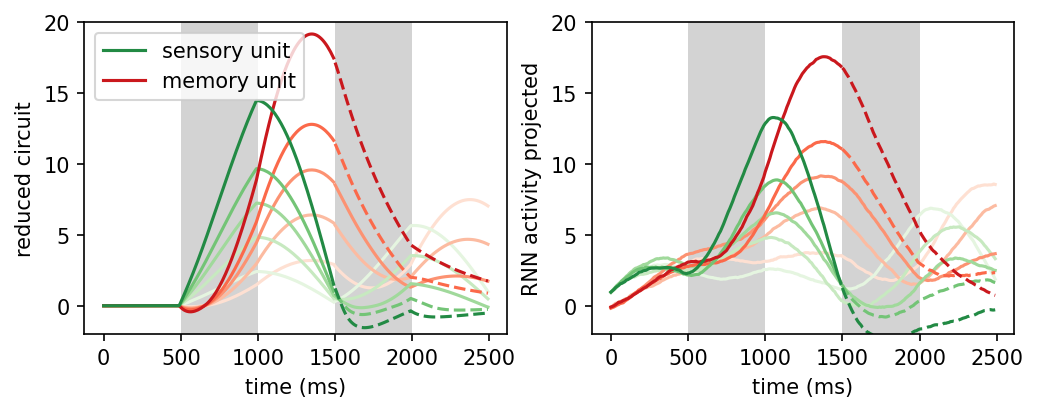

In [48]:
fig,(ax,ax1) = plt.subplots(figsize=(8,2.7),dpi=150,ncols=2)
time = np.arange(0,2500,10)
reds = plt.get_cmap('Reds')
greens = plt.get_cmap('Greens')
for qA,qB in [(2,1),(2,2),(2,3),(2,4),(2,6)]:
    ax.fill_between([500,1000],-3,22,color='lightgrey',edgecolor=None)
    ax.fill_between([1500,2000],-3,22,color='lightgrey',edgecolor=None)
    a=qA/4
    b=qB/8
    trialAvgBA,stdBA = getTrialAverage(state_pred_project,qA,qB,seqAB = 'BA')
    line11,=ax.plot(time[0:150],trialAvgBA[0:150,1],color=reds(b))
    line21,=ax.plot(time[0:150],trialAvgBA[0:150,0],color=greens(b))
    line12,=ax.plot(time[150:],trialAvgBA[150:,1],color=reds(b))
    line22,=ax.plot(time[150:],trialAvgBA[150:,0],color=greens(b))
    if (qA*1.7)<qB: 
        line12.set_linestyle('--')
        line22.set_linestyle('--')

ax.set_xlabel('time (ms)')
ax.set_ylabel('reduced circuit')
ax.set_ylim([-2,20])
ax.legend([line21,line11],['sensory unit','memory unit'])


for qA,qB in [(2,1),(2,2),(2,3),(2,4),(2,6)]:
    ax1.fill_between([500,1000],-3,22,color='lightgrey',edgecolor=None)
    ax1.fill_between([1500,2000],-3,22,color='lightgrey',edgecolor=None)
    a=qA/4
    b=qB/8
    trialAvgBA,stdBA = getTrialAverage(model_state_project,qA,qB,seqAB = 'BA')
    line11,=ax1.plot(time[0:150],trialAvgBA[0:150,1],color=reds(b))
    line21,=ax1.plot(time[0:150],trialAvgBA[0:150,0],color=greens(b))
    line12,=ax1.plot(time[150:],trialAvgBA[150:,1],color=reds(b))
    line22,=ax1.plot(time[150:],trialAvgBA[150:,0],color=greens(b))
    if (qA*1.7)<qB: 
        line12.set_linestyle('--')
        line22.set_linestyle('--')

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('RNN activity projected')
ax1.set_ylim([-2,20])
# fig.savefig('/gpfsnyu/scratch/jtg374/psychrnn/Figure/Fig6/Fig6E.pdf')

/tmp/ipykernel_3905313/1471548046.py:6: RuntimeWarning: Mean of empty slice.
  return model_state[idx,:,:].mean(axis=0),model_state[idx,:,:].std(axis=0)


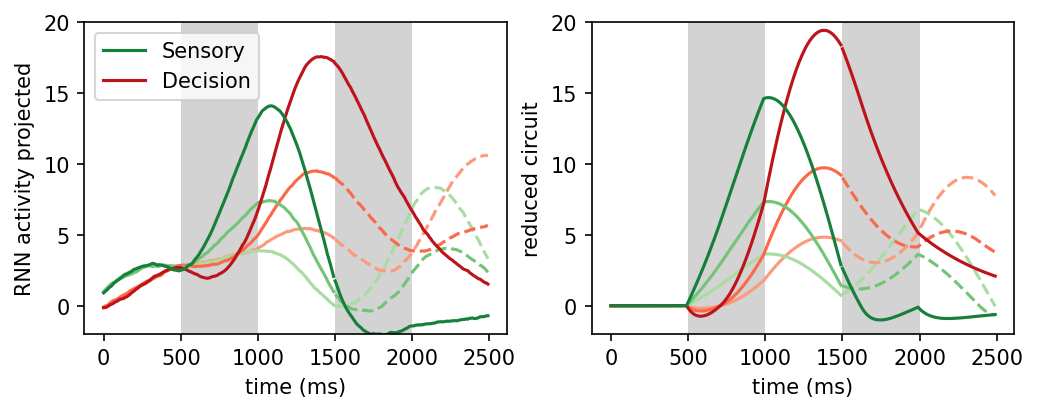

In [50]:
#!!!!! Need ActivityTestGrid data for this plot
fig,(ax1,ax) = plt.subplots(figsize=(8,2.7),dpi=150,ncols=2)
time = np.arange(0,2500,10)
reds = plt.get_cmap('Reds')
greens = plt.get_cmap('Greens')
for qA,qB in [(0,4),(1,4),(2,4),(3,4),(4,4)]:
    ax.fill_between([500,1000],-3,22,color='lightgrey',edgecolor=None)
    ax.fill_between([1500,2000],-3,22,color='lightgrey',edgecolor=None)
    a=qA/4
    a = a*0.6+0.2
    # b=qB/9
    trialAvgBA,stdBA = getTrialAverage(state_pred_project,qA,qB,seqAB = 'AB')
    line11,=ax.plot(time[0:150],trialAvgBA[0:150,1],color=reds(a))
    line21,=ax.plot(time[0:150],trialAvgBA[0:150,0],color=greens(a))
    line12,=ax.plot(time[150:],trialAvgBA[150:,1],color=reds(a))
    line22,=ax.plot(time[150:],trialAvgBA[150:,0],color=greens(a))
    if (qA*1.7)<qB: 
        line12.set_linestyle('--')
        line22.set_linestyle('--')

ax.set_xlabel('time (ms)')
ax.set_ylabel('reduced circuit')
ax.set_ylim([-2,20])


for qA,qB in [(0,4),(1,4),(2,4),(3,4),(4,4)]:
    ax1.fill_between([500,1000],-3,22,color='lightgrey',edgecolor=None)
    ax1.fill_between([1500,2000],-3,22,color='lightgrey',edgecolor=None)
    a=qA/4
    a = a*0.6+0.2
    # b=qB/9
    trialAvgBA,stdBA = getTrialAverage(model_state_project,qA,qB,seqAB = 'AB')
    line11,=ax1.plot(time[0:150],trialAvgBA[0:150,1],color=reds(a))
    line21,=ax1.plot(time[0:150],trialAvgBA[0:150,0],color=greens(a))
    line12,=ax1.plot(time[150:],trialAvgBA[150:,1],color=reds(a))
    line22,=ax1.plot(time[150:],trialAvgBA[150:,0],color=greens(a))
    if (qA*1.7)<qB: 
        line12.set_linestyle('--')
        line22.set_linestyle('--')

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('RNN activity projected')
ax1.set_ylim([-2,20])
ax1.legend([line21,line11],['Sensory','Decision'])

fig.savefig('/gpfsnyu/scratch/jtg374/psychrnn/Figure/Fig6/Fig6E.pdf')

In [51]:
from scipy.optimize import fsolve
def getNullclines(dirPath,xmin,xmax,ymin,ymax,inputA=0,inputB=0):

    W_rec = np.load(dirPath + '/circuitInfer/wRec.npy')
    W_in = np.load(dirPath + '/circuitInfer/wIn.npy')[0:2,0:2]

    relu = lambda x: x*(x>0)
    tau=100
    def F(x,x_in=np.zeros((2,1))):
        dxdt = (-x + W_in @ x_in + W_rec @ relu(x))/tau
        return dxdt
    def F0(x,y,pos,x_in=np.zeros((2,1))):
        dxdt = (-x + W_in[0,:] @ x_in + W_rec[0,0]*relu(x) + W_rec[0,1]*relu(y))
        dydt = (-y + W_in[1,:] @ x_in + W_rec[1,0]*relu(x) + W_rec[1,1]*relu(y))
        return dxdt if pos==0 else dydt
        
    x_in = np.array([[inputA/4],[inputB/8]])

    N_nullcline = 50
    X = np.linspace(xmin,xmax,N_nullcline)
    Y = np.linspace(ymin,ymax,N_nullcline)
    fX = np.zeros(N_nullcline)
    fY = np.zeros(N_nullcline)
    for ii,x in enumerate(X):
        fY[ii] = fsolve(lambda y: F0(x,y,pos=0,x_in=x_in),0.5)
    for ii,y in enumerate(Y):
        fX[ii] = fsolve(lambda x: F0(x,y,pos=1,x_in=x_in),0.5)
    return X,Y,fX,fY
X,Y,fX,fY = getNullclines(dirPath,-2,10,-3,18)

/tmp/ipykernel_3905313/1417262913.py:27: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  fX[ii] = fsolve(lambda x: F0(x,y,pos=1,x_in=x_in),0.5)


/gpfsnyu/home/jtg374/.conda/envs/torch_sklearn_dsa/lib/python3.10/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/tmp/ipykernel_3905313/1417262913.py:27: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  fX[ii] = fsolve(lambda x: F0(x,y,pos=1,x_in=x_in),0.5)


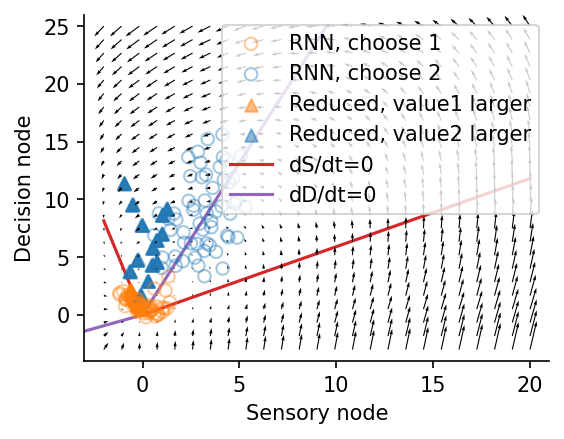

In [55]:
value1 = np.array([qAs[i]*1.7 if seqAB[i]=='AB' else qBs[i] for i in range(len(trial_params))])
value2 = np.array([qAs[i]*1.7 if seqAB[i]=='BA' else qBs[i] for i in range(len(trial_params))])

fig,ax = plt.subplots(figsize=(4,3),dpi=150)

ax.scatter(model_state_project[choice12=='1',-1,0],model_state_project[choice12=='1',-1,1],
           label='RNN, choose 1',
           edgecolors='tab:orange',marker='o',facecolors='none',alpha=0.4,zorder=3)
ax.scatter(model_state_project[choice12=='2',-1,0],model_state_project[choice12=='2',-1,1],
           label='RNN, choose 2',
           edgecolors='tab:blue',marker='o',facecolors='none',alpha=0.4,zorder=3)
ax.scatter(state_pred_project[value1>value2,-1,0],state_pred_project[value1>value2,-1,1],
           label='Reduced, value1 larger',
           color='tab:orange',marker='^',alpha=0.5)
ax.scatter(state_pred_project[value1<value2,-1,0],state_pred_project[value1<value2,-1,1],
           label='Reduced, value2 larger',
           color='tab:blue',marker='^',alpha=0.5)
plotVecField(model2d,ax,min_h1=-2,max_h1=20,min_h2=-3,max_h2=25)
X,Y,fX,fY = getNullclines(dirPath,-2,20,-3,25)
ax.plot(X,fY,color='tab:red',label='dS/dt=0',zorder=0)
ax.plot(fX,Y,color='tab:purple',label='dD/dt=0',zorder=0)
ax.legend()
ax.set_xlim(-3,21)
ax.set_ylim(-4,26)
ax.set_xlabel('Sensory node')
ax.set_ylabel('Decision node')
fig.savefig('/gpfsnyu/scratch/jtg374/psychrnn/Figure/Fig6/Fig6D.pdf')

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from pathlib import Path
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression
import pandas as pd
import seaborn as sns

csv_order = pd.read_csv('/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/0-analysis/activityAnalysis.orderTaskDefault.csv',
    header=1)    
pathList = csv_order[csv_order['angle_AB_encoding_tDelay']<5/180*np.pi]['dirPath']

self1 = []
self2 = []
negFdbk = []
mu = []
for i,dirPath in enumerate(pathList):
    w_rec = np.load(os.path.join(dirPath,'circuitInfer/wRec.npy'))
    w_in = np.load(os.path.join(dirPath,'circuitInfer/wIn.npy'))
    if w_rec[0,1]*w_rec[1,0]>=0:
        print(dirPath)
        continue

    negFdbk.append(w_rec[0,1]*w_rec[1,0])    
    if w_rec[0,1]<0:
        self1.append(w_rec[0,0])
        self2.append(w_rec[1,1])
        mu.append(w_in[1].mean()/w_in[0].mean()/w_rec[1,0])
    else:
        self2.append(w_rec[0,0])
        self1.append(w_rec[1,1])
        mu.append(w_in[0].mean()/w_in[1].mean()/w_rec[0,1])

    # if self1[-1]<1:
    #     print(dirPath)

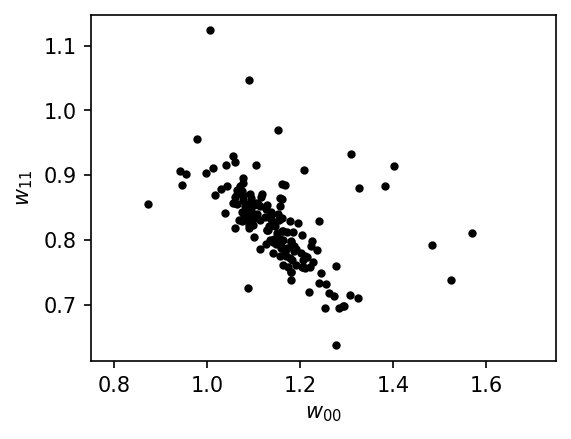

In [33]:
fig=plt.figure(dpi=150,figsize=(4,3))
plt.plot(self1,self2,'k.')
plt.xlabel('$w_{00}$')
plt.ylabel('$w_{11}$')
plt.xlim((0.75,1.75))
fig.savefig('/gpfsnyu/scratch/jtg374/psychrnn/Figure/Fig6/Fig6F.pdf')


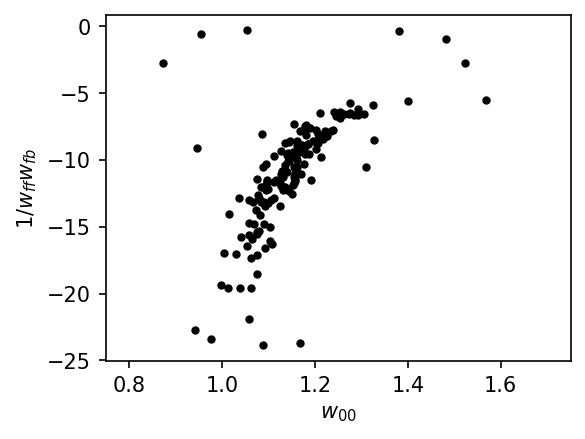

In [34]:
fig=plt.figure(dpi=150,figsize=(4,3))
plt.plot(self1,1/np.array(negFdbk),'k.')
plt.xlabel('$w_{00}$')
plt.ylabel('$1/w_{ff}w_{fb}$')
plt.xlim((0.75,1.75))
fig.savefig('/gpfsnyu/scratch/jtg374/psychrnn/Figure/Fig6/Fig6G.pdf')
